# Emergency Framework Analysis

**Purpose:** To help proactively prioritize AA frameworks for 2026

**Parameters Considered:** Previous allocations (number of allocations and median budget), CIRV score, food security analysis, and more.

**Other Data Points Considered:** AA frameworks developed by partners and other organizations, HNRP status

**Recommendations (living analysis):**

| Climate Shock | Priority Countries for 2026 |
| -------- | ------- |
| Cholera | Haiti and Zimbabwe |
| Drought | Zimbabwe, Angol, and Mauritania |
| Floods | Somalia and Mozambique
| Storms | Malawi, Guatemala, and Vanuatu

---



## Interactive Dashboard

In [ ]:
import os, re, io, base64, requests
import pandas as pd
import numpy as np
from IPython.display import display, HTML

# ---------------- CONFIG ----------------
# For Voilà/Binder, use a relative path in your repo, e.g. "data/Yakubu Analysis Updated.xlsx"
INPUT_PATH = "Yakubu Analysis Updated.xlsx"  # allocations workbook

# Widgets
try:
    from ipywidgets import Dropdown, HBox, VBox, Layout, Output, Checkbox, SelectMultiple, Button
    _HAS_WIDGETS = True
except Exception:
    _HAS_WIDGETS = False

import pycountry

# Attempt Colab callback support (for clickable cards in Colab only)
try:
    from google.colab import output as _colab_output
    _HAS_COLAB = True
except Exception:
    _HAS_COLAB = False

# ---------------- Hard-coded IPC 3+ in DECIMALS (map by ISO-3) ----------------
IPC3_BY_ISO3 = {
    "AFG":0.27,"AGO":0.49,"BDI":0.15,"BEN":0.03,"BFA":0.07,"BGD":0.16,"CAF":0.34,"CIV":0.05,
    "CMR":0.00,"COD":0.22,"CPV":0.00,"DJI":0.17,"DOM":0.09,"ECU":0.14,"ETH":0.30,"GHA":0.07,
    "GIN":0.13,"GMB":0.00,"GNB":0.07,"GTM":0.17,"HND":0.18,"HTI":0.48,"KEN":0.11,"LBN":0.21,
    "LBR":0.08,"LSO":0.19,"MDG":0.15,"MLI":0.00,"MOZ":0.28,"MRT":0.07,"MWI":0.20,"NAM":0.38,
    "NER":0.00,"NGA":0.12,"PAK":0.22,"PSE":1.00,"SDN":0.45,"SEN":0.00,"SLE":0.11,"SLV":0.13,
    "SOM":0.17,"SSD":0.47,"SWZ":0.16,"TCD":0.13,"TGO":0.10,"TLS":0.27,"TZA":0.10,"UGA":0.17,
    "YEM":0.49,"ZAF":0.16,"ZMB":0.29,"ZWE":0.27
}

# ---------------- Helpers ----------------
def _clean_cols(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [' '.join([str(x) for x in tup if str(x) != 'nan']).strip() for x in df.columns.values]
    df.columns = [re.sub(r'\s+', ' ', str(c)).strip() for c in df.columns]
    return df

def _to_num(x):
    if pd.isna(x): return np.nan
    s = str(x).replace(",", "")
    s = re.sub(r'[\$\u20AC\u00A3%]', '', s)
    try: return float(s)
    except: return np.nan

def _auto_sheet():
    xl = pd.ExcelFile(INPUT_PATH)
    return xl.sheet_names[0]

def _load_sheet(sheet_name=None):
    if sheet_name is None:
        sheet_name = _auto_sheet()
    df = pd.read_excel(INPUT_PATH, sheet_name=sheet_name)
    return _clean_cols(df)

def _col_for(patterns, cols):
    for p in patterns:
        for c in cols:
            if re.search(p, c, flags=re.I):
                return c
    return None

def _detect_base_cols(df):
    cols = list(df.columns)
    country = _col_for([r'^country$', r'country\s*name', r'location', r'iso.*name'], cols)
    cirv = _col_for([r'\bcirv\b', r'index.*risk', r'vulnerab'], cols)
    return country, cirv

def _detect_shock_cols(df, shock):
    cols = list(df.columns)
    amt = _col_for([fr'{shock}.*ufe\+?rr.*\$', fr'{shock}.*total.*\$', fr'{shock}.*alloc.*\$', fr'{shock}.*usd'], cols)
    cnt = _col_for([fr'{shock}.*(ufe\s*rr|ufe\+?rr).*(#|count|num|number)'], cols)
    ufe_amt = _col_for([fr'{shock}.*\bufe\b.*\$', fr'{shock}.*underfunded.*\$', fr'{shock}.*\bufe\b', fr'{shock}.*underfunded\s*emergency'], cols)
    rr_amt  = _col_for([fr'{shock}.*\brr\b.*\$', fr'{shock}.*rapid\s*response.*\$', fr'{shock}.*rapid\s*response'], cols)
    ufe_cnt = _col_for([fr'{shock}.*\bufe\b.*(#|count|num|number)'], cols)
    rr_cnt  = _col_for([fr'{shock}.*\brr\b.*(#|count|num|number)'], cols)
    fw = _col_for([fr'{shock}.*framework.*status', fr'{shock}.*aa\s*framework', fr'{shock}.*trigger.*status', fr'{shock}.*framework'], cols)
    tier = _col_for([fr'{shock}.*tier'], cols)
    return {"amt": amt, "cnt": cnt, "ufe_amt": ufe_amt, "rr_amt": rr_amt,
            "ufe_cnt": ufe_cnt, "rr_cnt": rr_cnt, "fw": fw, "tier": tier}

def _detect_funding_plan_col(df):
    cols = list(df.columns)
    patterns = [
        r'fund(ing)?\s*plan', r'(hnrp)\s*plan', r'flash\s*appeal',
        r'(response|humanitarian)\s*plan', r'\bappeal\b', r'\bhnrp\b',
    ]
    return _col_for(patterns, cols)

def _normalize_fields(df, cols_detected, cirv_col):
    df = df.copy()
    for key in ["amt", "ufe_amt", "rr_amt"]:
        col = cols_detected.get(key)
        if col and col in df.columns:
            df[col] = df[col].map(_to_num)
    for key in ["cnt", "ufe_cnt", "rr_cnt"]:
        col = cols_detected.get(key)
        if col and col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    if cirv_col and cirv_col in df.columns:
        df[cirv_col] = df[cirv_col].map(_to_num)
    return df

def _format_currency(series, blank_zero=False):
    def fmt(v):
        if pd.isna(v): return ""
        v = float(v)
        if blank_zero and abs(v) < 0.5: return ""
        return f"{int(round(v)):,}"
    return series.apply(fmt)

def _format_count(series):
    s = pd.to_numeric(series, errors="coerce").round(0)
    return s.apply(lambda v: "" if pd.isna(v) else str(int(v)))

# ---------- Country name normalization & ISO-3 ----------
_ALIAS_TO_CANON = {
    "DR Congo": "Congo, The Democratic Republic of the",
    "Dem. Rep. Congo": "Congo, The Democratic Republic of the",
    "Democratic Republic of Congo": "Congo, The Democratic Republic of the",
    "Congo, Dem. Rep.": "Congo, The Democratic Republic of the",
    "Congo (Brazzaville)": "Congo",
    "Cote d'Ivoire": "Côte d'Ivoire",
    "Cote dIvoire": "Côte d'Ivoire",
    "Ivory Coast": "Côte d'Ivoire",
    "Swaziland": "Eswatini",
    "Burma": "Myanmar",
    "Czech Republic": "Czechia",
    "Macedonia": "North Macedonia",
    "Turkey": "Türkiye",
    "Turkiye": "Türkiye",
    "Laos": "Lao People's Democratic Republic",
    "Lao PDR": "Lao People's Democratic Republic",
    "Cape Verde": "Cabo Verde",
    "Palestine": "Palestine, State of",
    "Syria": "Syrian Arab Republic",
    "Moldova": "Moldova, Republic of",
    "Russia": "Russian Federation",
}
def _name_alias(nm: str) -> str:
    nm = (nm or "").strip()
    return _ALIAS_TO_CANON.get(nm, nm)

def _name_to_iso3(nm: str) -> str:
    nm = _name_alias(nm)
    try:
        return pycountry.countries.search_fuzzy(nm)[0].alpha_3.upper()
    except Exception:
        special = {
            "Congo, The Democratic Republic of the": "COD",
            "Cabo Verde": "CPV",
            "Côte d'Ivoire": "CIV",
            "Palestine, State of": "PSE",
            "Russian Federation": "RUS",
            "Syrian Arab Republic": "SYR",
            "Lao People's Democratic Republic": "LAO",
            "Moldova, Republic of": "MDA",
            "Türkiye": "TUR",
        }
        return special.get(nm, None)

# -------- Anticipation Hub frameworks (LAZY to keep Binder fast) --------
AA_MODE = "lazy"   # set to "off" to skip fetching completely

def _extract_src_from_office_online_url(office_online_url):
    from urllib.parse import urlparse, parse_qs
    parsed = urlparse(office_online_url); q = parse_qs(parsed.query)
    return q.get("src", [None])[0]

def load_aa_frameworks(timeout=15):
    """Download Anticipation Hub tables and return normalized rows."""
    dev_url = "https://view.officeapps.live.com/op/view.aspx?src=https%3A%2F%2Fwww.anticipation-hub.org%2FDocuments%2FReports%2FOverview-report-2024%2FTable_A3._Frameworks_under_development_in_2024_FINAL_TABLE.xlsx&wdOrigin=BROWSELINK"
    act_url = "https://view.officeapps.live.com/op/view.aspx?src=https%3A%2F%2Fwww.anticipation-hub.org%2FDocuments%2FReports%2FOverview-report-2024%2FTable_A2._Active_frameworks_in_2024_FINAL_TABLE.xlsx&wdOrigin=BROWSELINK"
    src_dev = _extract_src_from_office_online_url(dev_url)
    src_act = _extract_src_from_office_online_url(act_url)
    if not (src_dev and src_act):
        return pd.DataFrame(columns=["_iso3","status","_hazard","_org"])

    def _fetch_xlsx(url):
        try:
            r = requests.get(url, timeout=timeout)
            r.raise_for_status()
            return pd.read_excel(io.BytesIO(r.content), engine="openpyxl")
        except Exception:
            return pd.DataFrame()

    df_dev = _fetch_xlsx(src_dev)
    df_act = _fetch_xlsx(src_act)
    if df_dev.empty and df_act.empty:
        return pd.DataFrame(columns=["_iso3","status","_hazard","_org"])

    def clean_cols(cols):
        out=[]
        for c in cols:
            s = str(c).strip().lower()
            s = re.sub(r"[^\w\s]", "", s)
            s = re.sub(r"\s+", "_", s)
            out.append(s)
        return out

    if not df_dev.empty:
        df_dev.columns = clean_cols(df_dev.columns)
        df_dev["status"] = "Under Development"
    if not df_act.empty:
        df_act.columns = clean_cols(df_act.columns)
        df_act["status"] = "Active"

    df_all = pd.concat([df_dev, df_act], ignore_index=True, sort=False)
    cols = list(df_all.columns)

    # country column -> ISO3
    ctry_col = _col_for([r'^country$', r'country.*name', r'country'], cols)
    df_all["_country_tmp"] = df_all[ctry_col].astype(str).str.strip() if ctry_col else ""
    df_all["_iso3"] = df_all["_country_tmp"].map(lambda x: _name_to_iso3(_name_alias(x)))

    # hazard-like columns
    hazard_candidates = [
        r'\bhazard(s)?\b', r'\bshock(s)?\b', r'\btrigger(s)?\b', r'\bevent\b',
        r'\bhazard_?type\b', r'\btype\b', r'\bperil\b', r'\brisk\b',
        r'\bhazard_?category\b', r'\bshock_?type\b', r'\bhazard_?name\b'
    ]
    haz_cols = []
    for pat in hazard_candidates:
        c = _col_for([pat], cols)
        if c and c not in haz_cols:
            haz_cols.append(c)

    # coord/org columns
    org_candidates = [
        r'coordinat(ing|ion|or)', r'lead(_)?(agency|org|organization)',
        r'\borg(anization)?\b', r'\bagency\b', r'partner', r'institution',
        r'ministry', r'authority'
    ]
    org_cols = []
    for pat in org_candidates:
        c = _col_for([pat], cols)
        if c and c not in org_cols:
            org_cols.append(c)

    # known hazard keywords (fallback scan)
    HAZ_KW = [
        "flood","floods","riverine flood","flash flood","coastal flood",
        "drought","dry spell","heatwave","heat wave","coldwave","cold wave",
        "storm","windstorm","severe storm","tropical storm","cyclone","hurricane","typhoon",
        "landslide","mudslide","avalanche",
        "earthquake","seismic","tsunami","volcano","volcanic eruption",
        "wildfire","bushfire","forest fire",
        "epidemic","pandemic","cholera","disease outbreak","outbreak",
        "food insecurity","locust","pluvial flood"
    ]
    HAZ_RE = re.compile(r'\b(' + "|".join(map(re.escape, HAZ_KW)) + r')\b', flags=re.I)

    def _tidy(s):
        s = (str(s) if not pd.isna(s) else "").strip()
        s = re.sub(r"\s+", " ", s)
        return s

    def build_hazard(row):
        vals = []
        for c in haz_cols:
            vals.append(_tidy(row.get(c, "")))
        vals = [v for v in vals if v]
        if vals:
            main = vals[0]
            extra = next((v for v in vals[1:] if v.lower() != main.lower()), "")
            return f"{main} / {extra}" if extra else main
        found = []
        for v in row.values:
            s = _tidy(v)
            if not s: continue
            for m in HAZ_RE.findall(s):
                token = m.strip()
                if token and token.lower() not in [x.lower() for x in found]:
                    found.append(token)
        if found:
            return f"{found[0]} / {found[1]}" if len(found) >= 2 else found[0]
        return ""

    def build_org(row):
        for c in org_cols:
            val = _tidy(row.get(c, ""))
            if val:
                parts = re.split(r"[;/,\u2013\u2014\-]+", val)
                parts = [p.strip() for p in parts if p.strip()]
                if parts:
                    return parts[0]
        return ""

    out = df_all.assign(
        _hazard=df_all.apply(build_hazard, axis=1),
        _org=df_all.apply(build_org, axis=1)
    )[[ "_iso3", "status", "_hazard", "_org" ]]
    out = out[(out["_iso3"].notna()) & ((out["_hazard"].str.strip()!="") | (out["_org"].str.strip()!=""))]
    return out

# Lazy caches
AA_FLAGS_ISO, AA_DETAILS_ISO, _AA_LOADED = {}, {}, False

def _build_aa_maps(df):
    flags, details = {}, {}
    if df is None or df.empty:
        return flags, details
    tmp = df.copy()
    tmp["_iso3"] = tmp["_iso3"].astype(str)
    for iso, sub in tmp.groupby("_iso3"):
        if iso not in details:
            details[iso] = {"Active": [], "Under Development": []}
        has_any = False
        for _, r in sub.iterrows():
            haz = str(r.get("_hazard","")).strip()
            org = str(r.get("_org","")).strip()
            status = str(r.get("status","")).strip()
            bits = [b for b in [haz, org] if b]
            if not bits: continue
            label = " — ".join(bits)
            if status in details[iso]:
                if label not in details[iso][status]:
                    details[iso][status].append(label)
                has_any = True
        flags[iso] = has_any
    return flags, details

def ensure_aa_loaded():
    """Load AA tables once (unless AA_MODE='off')."""
    global AA_FLAGS_ISO, AA_DETAILS_ISO, _AA_LOADED
    if _AA_LOADED or AA_MODE == "off":
        _AA_LOADED = True
        return
    try:
        df = load_aa_frameworks(timeout=15)
    except Exception:
        df = pd.DataFrame()
    AA_FLAGS_ISO, AA_DETAILS_ISO = _build_aa_maps(df)
    _AA_LOADED = True

# ----- Details HTML -----
def _render_country_details(row, fw_col, cirv_col, amt_col, funding_plan_col, cols):
    # Make sure AA data is available for details (lazy)
    ensure_aa_loaded()

    fw_v = row.get(fw_col, "")
    fw_str = "" if str(fw_v).strip().lower() in {"inactive","0","0.0","0.00"} else str(fw_v or "")
    cirv = row.get(cirv_col, np.nan)
    ipc  = row.get("IPC3plus", np.nan)
    rr_amt = row.get(cols.get("rr_amt"), np.nan)
    rr_cnt = row.get(cols.get("rr_cnt"), np.nan)
    ufe_amt= row.get(cols.get("ufe_amt"), np.nan)
    ufe_cnt= row.get(cols.get("ufe_cnt"), np.nan)
    amt    = row.get(amt_col, np.nan)
    fplan  = row.get(funding_plan_col, "") if funding_plan_col else ""
    country= str(row["Country"])
    iso3   = _name_to_iso3(country) or ""

    def pct(v):  return "" if (pd.isna(v) or float(v)<=0) else f"{int(round(float(v)*100))}%"
    def cur(v):  return "" if pd.isna(v) else f"{int(round(float(v))):,}"
    def cnt(v):
        v = pd.to_numeric(pd.Series([v]), errors="coerce").iloc[0]
        return "" if pd.isna(v) else str(int(round(float(v))))

    # Other AA frameworks (lists) via ISO-3
    by_iso = AA_DETAILS_ISO.get(iso3, {"Active": [], "Under Development": []})
    act_list = by_iso.get("Active", [])
    dev_list = by_iso.get("Under Development", [])
    def _fmt_list(lst):
        if not lst: return "<span style='color:#666;'>None</span>"
        items = [f"<li>{str(x)}</li>" for x in lst]
        return "<ul style='margin:0 0 0 16px;padding:0;'>{}</ul>".format("".join(items))

    return f"""
    <div style="border:1px solid #e5e7eb;border-radius:10px;padding:10px;margin:10px 0;background:#fff;">
      <div style="font-weight:800;font-size:16px;margin-bottom:6px;">{country} — Details</div>
      <div style="display:grid;grid-template-columns:1fr 1fr;gap:8px 18px;font-size:13px;">
        <div><b>Funding Plan</b></div><div>{fplan if fplan else ''}</div>
        <div><b>Other AA (in 2024)</b></div><div>{_fmt_list(act_list)}</div>
        <div><b>Other AA (Under Development)</b></div><div>{_fmt_list(dev_list)}</div>
        <div><b>Framework Status</b></div><div>{fw_str}</div>
        <div><b>CIRV</b></div><div>{'' if pd.isna(cirv) else int(round(float(cirv)))}</div>
        <div><b>IPC 3+ (%)</b></div><div>{pct(ipc)}</div>
        <div><b>RR Allocations ($)</b></div><div>{cur(rr_amt)}</div>
        <div><b>RR Count (#)</b></div><div>{cnt(rr_cnt)}</div>
        <div><b>UFE Allocations ($)</b></div><div>{cur(ufe_amt)}</div>
        <div><b>UFE Count (#)</b></div><div>{cnt(ufe_cnt)}</div>
        <div><b>UFE+RR Amount ($)</b></div><div>{cur(amt)}</div>
      </div>
    </div>
    """

# ---------------- Core builder (now with Tier 3) ----------------
def build_view_and_dashboard(shock, sheet=None, top_n=30,
                             use_exclude_fw=True, use_cirv_med=False,
                             use_hnrp=False, use_food_insec=False, use_other_aa=False,
                             manual_remove_tier1=None, manual_add_countries=None):
    """
    Returns: dashboard_html, table_html, tier1_country_list, table_country_list,
             rows_df, cols_detected, cirv_col, amt_col, funding_plan_col
    """
    shock = shock.lower()
    assert shock in ("cholera","floods","drought","storms")
    # If filtering by "other AA", make sure AA flags are loaded
    if use_other_aa:
        ensure_aa_loaded()

    df = _load_sheet(sheet)
    country_col, cirv_col = _detect_base_cols(df)
    if not country_col:
        raise ValueError("Could not detect a country column.")
    cols = _detect_shock_cols(df, shock)
    if not cols["amt"]:
        raise ValueError(f"Could not detect a '{shock}' UFE+RR amount column.")
    df = _normalize_fields(df, cols, cirv_col)

    # Only countries with non-zero allocations for this shock
    sel = df[df[cols["amt"]].fillna(0) > 0].copy()

    # Keep Tier 1 & 2 in table (Tier 3 is a render-time concept)
    if cols["tier"] and cols["tier"] in sel.columns:
        tnorm = sel[cols["tier"]].astype(str).str.extract(r'(Tier\s*\d)', expand=False)
        sel["_TierNorm"] = tnorm.fillna(sel[cols["tier"]].astype(str))
        sel = sel[sel["_TierNorm"].str.contains(r'(?i)Tier\s*1|Tier\s*2', na=False)]
    else:
        sel["_TierNorm"] = np.nan

    # Country, ISO3, IPC
    if "Country" not in sel.columns and country_col != "Country":
        sel = sel.rename(columns={country_col: "Country"})
    sel["Country"] = sel["Country"].astype(str).str.strip()
    sel["ISO3"] = sel["Country"].map(_name_to_iso3)
    sel["IPC3plus"] = sel["ISO3"].map(IPC3_BY_ISO3)  # decimal (0–1)

    # Funding Plan + HNRP + HasFundingPlan
    funding_plan_col = _detect_funding_plan_col(sel)
    if funding_plan_col is None:
        funding_plan_col = _col_for([r'plan', r'appeal', r'(hnrp)'], list(sel.columns))
    if funding_plan_col and funding_plan_col in sel.columns:
        sel[funding_plan_col] = sel[funding_plan_col].astype(str).replace({"nan":"", "NaN":"", "None":""})
        sel[funding_plan_col] = sel[funding_plan_col].apply(lambda s: "" if str(s).strip() in {"0","0.0","0.00"} else s)
        sel["HNRP"] = sel[funding_plan_col].str.contains(r'\bHNRP\b', case=False, na=False)
        sel["HasFundingPlan"] = sel[funding_plan_col].str.strip().ne("")
    else:
        sel["HNRP"] = False
        sel["HasFundingPlan"] = False

    # Other AA frameworks flags via ISO3
    sel["HasOtherAA"] = sel["ISO3"].map(lambda iso: bool(AA_FLAGS_ISO.get(iso or "", False)))

    fw_col  = cols["fw"]
    amt_col = cols["amt"]

    # ----------- Build table (also used for ranges & add dropdown) -----------
    labels = {"Country": "Country"}
    disp_cols = ["Country"]
    if "_TierNorm" in sel.columns and not sel["_TierNorm"].isna().all():
        disp_cols.append("_TierNorm"); labels["_TierNorm"] = "Tier"
    if cirv_col:
        disp_cols.append(cirv_col); labels[cirv_col] = "CIRV"
    disp_cols.append("IPC3plus"); labels["IPC3plus"] = "IPC 3+ (%)"
    if funding_plan_col and funding_plan_col in sel.columns:
        disp_cols.append(funding_plan_col); labels[funding_plan_col] = "Funding Plan"
    if fw_col:
        disp_cols.append(fw_col); labels[fw_col] = f"{shock.capitalize()} Framework Status"
    disp_cols.append(amt_col); labels[amt_col] = f"{shock.capitalize()} UFE+RR Amount ($)"
    if cols["cnt"]:
        disp_cols.append(cols["cnt"]); labels[cols["cnt"]] = f"{shock.capitalize()} UFE+RR Count (#)"
    else:
        sel[f"__{shock}_cnt__"] = np.nan
        disp_cols.append(f"__{shock}_cnt__"); labels[f"__{shock}_cnt__"] = f"{shock.capitalize()} UFE+RR Count (#)"
    # UFE + RR
    for k, lab in [("ufe_amt","UFE Allocations ($)"),("ufe_cnt","UFE Count (#)"),
                   ("rr_amt","RR Allocations ($)"),("rr_cnt","RR Count (#)")]:
        c = cols.get(k)
        if c and (k.endswith("amt") and c!=amt_col):
            disp_cols.append(c); labels[c] = f"{shock.capitalize()} {lab}"
        elif c and k.endswith("cnt"):
            disp_cols.append(c); labels[c] = f"{shock.capitalize()} {lab}"
        else:
            tmp = f"__{shock}_{k}__"
            sel[tmp] = np.nan
            disp_cols.append(tmp); labels[tmp] = f"{shock.capitalize()} {lab}"

    view = sel[disp_cols].rename(columns=labels).copy()

    # Ranges for color (full table)
    def _rng(s):
        s = pd.to_numeric(s, errors="coerce")
        return (float(s.min()), float(s.max())) if s.notna().any() else (np.nan,np.nan)
    num_ranges = {}
    if "CIRV" in view.columns: num_ranges["CIRV"] = _rng(view["CIRV"])
    num_ranges["IPC3plus"] = _rng(sel["IPC3plus"])
    num_ranges[f"{shock.capitalize()} UFE+RR Amount ($)"] = _rng(sel[amt_col])
    for name in [f"{shock.capitalize()} UFE+RR Count (#)",
                 f"{shock.capitalize()} UFE Allocations ($)",
                 f"{shock.capitalize()} UFE Count (#)",
                 f"{shock.capitalize()} RR Allocations ($)",
                 f"{shock.capitalize()} RR Count (#)"]:
        base_key = None
        if name.endswith("UFE+RR Count (#)") and cols["cnt"]: base_key = cols["cnt"]
        elif "UFE Allocations" in name and cols["ufe_amt"]:   base_key = cols["ufe_amt"]
        elif "UFE Count" in name and cols["ufe_cnt"]:         base_key = cols["ufe_cnt"]
        elif "RR Allocations" in name and cols["rr_amt"]:     base_key = cols["rr_amt"]
        elif "RR Count" in name and cols["rr_cnt"]:           base_key = cols["rr_cnt"]
        if base_key and base_key in sel.columns:
            num_ranges[name] = _rng(sel[base_key])

    # -------- Apply dashboard criteria to build ranked base --------
    ds = sel.copy()
    if use_exclude_fw and fw_col and fw_col in ds.columns:
        bad = ds[fw_col].astype(str).str.strip().str.lower()
        ds = ds[~bad.isin({"active","dormant","under development","under-development","under_development"})]
    if use_cirv_med and cirv_col and cirv_col in ds.columns:
        top10 = sel.sort_values(by=amt_col, ascending=False).head(10)
        cirv_median_top10 = float(top10[cirv_col].median()) if not top10.empty else np.nan
        if pd.notna(cirv_median_top10):
            ds = ds[ds[cirv_col] > cirv_median_top10]
    if use_hnrp:
        ds = ds[ds["HNRP"] == True]
    if use_food_insec:
        ds = ds[(~ds["IPC3plus"].isna()) & (ds["IPC3plus"] > 0)]
    if use_other_aa:
        ds = ds[ds["HasOtherAA"] == True]

    ranked = ds.sort_values(by=amt_col, ascending=False).copy()

    # ---------- Manual overrides + 3 tiers ----------
    r_countries = ranked["Country"].tolist()
    tier1 = r_countries[:3]
    tier2 = r_countries[3:6]
    tier3 = r_countries[6:9]
    remaining = r_countries[9:]

    # 1) Remove (from Tier 1 only) + cascade refill (T2 -> T1, T3 -> T2, remaining -> fill)
    remove_set = set(manual_remove_tier1) if manual_remove_tier1 else set()
    if remove_set:
        tier1 = [c for c in tier1 if c not in remove_set]
        while len(tier1) < 3 and tier2:
            tier1.append(tier2.pop(0))
        while len(tier1) < 3 and tier3:
            tier1.append(tier3.pop(0))
        while len(tier1) < 3 and remaining:
            tier1.append(remaining.pop(0))
        while len(tier2) < 3 and tier3:
            tier2.append(tier3.pop(0))
        while len(tier2) < 3 and remaining:
            tier2.append(remaining.pop(0))
        while len(tier3) < 3 and remaining:
            tier3.append(remaining.pop(0))

    # 2) Add (MULTI, keep table order) to Tier 1; cascade bumps T1->T2->T3->remaining
    add_list = [c for c in (manual_add_countries or []) if isinstance(c, str) and c.strip()]
    table_order = view["Country"].tolist()
    add_list = [c for c in table_order if c in set(add_list)]  # stable order

    def apply_add(one):
        nonlocal tier1, tier2, tier3, remaining
        if one not in set(ranked["Country"].tolist()):
            return

        if one in tier1:
            if len(tier1) == 0 or tier1[-1] == one:
                return
            prev_last = tier1[-1] if len(tier1) >= 1 else None
            tier1 = [c for c in tier1 if c != one]
            bump = prev_last if prev_last and prev_last != one else None
            tier1.append(one)
        elif one in tier2:
            tier2.remove(one)
            prev_last = tier1[-1] if len(tier1) >= 1 else None
            if len(tier1) < 3:
                tier1.append(one); bump = None
            else:
                bump = prev_last; tier1[-1] = one
        else:
            if one in tier3:
                tier3.remove(one)
            elif one in remaining:
                remaining.remove(one)
            prev_last = tier1[-1] if len(tier1) >= 1 else None
            if len(tier1) < 3:
                tier1.append(one); bump = None
            else:
                bump = prev_last; tier1[-1] = one

        if 'bump' in locals() and bump:
            tier2.insert(0, bump)
        while len(tier2) > 3:
            overflow = tier2.pop()
            tier3.insert(0, overflow)
        while len(tier3) > 3:
            overflow = tier3.pop()
            remaining.insert(0, overflow)
        while len(tier2) < 3 and (tier3 or remaining):
            if tier3:
                tier2.append(tier3.pop(0))
            elif remaining:
                tier2.append(remaining.pop(0))
        while len(tier3) < 3 and remaining:
            tier3.append(remaining.pop(0))

    for to_add in add_list:
        apply_add(to_add)

    # --- Final sanity pass: drop vanished, dedup, and top-up all tiers ---
    available = set(ranked["Country"].tolist())

    def _dedup_keep(seq):
        seen=set(); out=[]
        for x in seq:
            if x not in seen:
                out.append(x); seen.add(x)
        return out

    tier1 = _dedup_keep([c for c in tier1 if c in available])
    tier2 = _dedup_keep([c for c in tier2 if (c in available and c not in tier1)])
    tier3 = _dedup_keep([c for c in tier3 if (c in available and c not in tier1 and c not in tier2)])
    remaining = [c for c in remaining if (c in available and c not in tier1 and c not in tier2 and c not in tier3)]

    while len(tier1) < 3 and (tier2 or tier3 or remaining):
        if tier2: tier1.append(tier2.pop(0))
        elif tier3: tier1.append(tier3.pop(0))
        elif remaining: tier1.append(remaining.pop(0))
    while len(tier2) < 3 and (tier3 or remaining):
        if tier3: tier2.append(tier3.pop(0))
        elif remaining: tier2.append(remaining.pop(0))
    while len(tier3) < 3 and remaining:
        tier3.append(remaining.pop(0))

    # Build tier DataFrames for rendering cards (missing-safe, preserve order)
    def take_rows(names):
        avail = set(ranked["Country"].tolist())
        order = [c for c in names if c in avail]
        if not order:
            return ranked.head(0).copy().reset_index(drop=True)
        sub = ranked[ranked["Country"].isin(order)].copy()
        sub["__order__"] = pd.Categorical(sub["Country"], categories=order, ordered=True)
        sub = sub.sort_values("__order__").drop(columns="__order__")
        return sub.reset_index(drop=True)

    tier1_df = take_rows(tier1)
    tier2_df = take_rows(tier2)
    tier3_df = take_rows(tier3)

    # Prepare table country list (no blanks)
    table_countries = sorted([c for c in view["Country"].unique().tolist() if str(c).strip()])

    # ---------- Color helpers ----------
    def _hex(x): return max(0, min(255, int(round(x))))
    def _interp_color(t):
        if np.isnan(t): return "#444"
        t = max(0.0, min(1.0, float(t)))
        if t < 0.5:
            u = t/0.5
            r = 0*(1-u) + 230*u
            g = 150*(1-u) + 180*u
            b = 0*(1-u) + 30*u
        else:
            u = (t-0.5)/0.5
            r = 230*(1-u) + 200*u
            g = 180*(1-u) + 40*u
            b = 30*(1-u) + 40*u
        return f"#{_hex(r):02x}{_hex(g):02x}{_hex(b):02x}"
    def _norm(v, vmin, vmax):
        v = float(v)
        if np.isnan(v) or np.isnan(vmin) or np.isnan(vmax) or vmax<=vmin: return np.nan
        return (v - vmin) / (vmax - vmin)
    def _span_val(val, rng_key, fmt=lambda x:x, blank_if_le=False):
        if pd.isna(val): return "<span class='v'></span>"
        if blank_if_le and float(val) <= 0: return "<span class='v'></span>"
        vmin, vmax = num_ranges.get(rng_key, (np.nan,np.nan))
        t = _norm(val, vmin, vmax)
        color = _interp_color(t)
        return f"<span class='v' style='color:{color}; font-weight:700;'>{fmt(val)}</span>"
    def _fmt_curr_raw(v):
        if pd.isna(v): return ""
        v = float(v); return f"{int(round(v)):,}"
    def _fmt_cnt_raw(v):
        v = pd.to_numeric(pd.Series([v]), errors="coerce").iloc[0]
        return "" if pd.isna(v) else str(int(round(float(v))))
    def _fmt_pct01_raw(v):
        if pd.isna(v) or float(v)<=0: return ""
        return f"{int(round(float(v)*100))}%"

    # ---- Cards ----
    def _card_country_anchor(name):
        if _HAS_COLAB:
            return f"<a href='#' onclick=\"google.colab.kernel.invokeFunction('notebook.clickCountry', ['{name}'], {{}}); return false;\" class='country-link'>{name}</a>"
        else:
            # Voilà / non-Colab: inline onclick calls a global we inject after render
            return ("<a href='#' class='country-link' "
                    "onclick='if(window.__AA_showDetails){window.__AA_showDetails((this.textContent||this.innerText||\"\" ).trim());} return false;'>"
                    f"{name}</a>")

    def _cards_html(df_part, label):
        if df_part.empty:
            return f"<div class='tier'><div class='tier-title'>{label}</div><div class='none'>No countries meet the selected criteria.</div></div>"
        cards=[]
        for _, row in df_part.iterrows():
            cirv_col_name = cirv_col  # capture
            cirv_html = ""
            if cirv_col_name and (not pd.isna(row.get(cirv_col_name))):
                cirv_html = _span_val(row[cirv_col_name], "CIRV", fmt=lambda x: str(int(round(float(x)))))
            ipc_html  = _span_val(row.get("IPC3plus"), "IPC3plus", fmt=_fmt_pct01_raw, blank_if_le=True)

            fw_v = row.get(fw_col, "")
            fw_str = ""
            if isinstance(fw_v, str):
                fw_str = "" if fw_v.strip().lower() in {"inactive","0","0.0","0.00"} else fw_v

            rr_amt_html  = _span_val(row.get(cols.get("rr_amt")),  f"{shock.capitalize()} RR Allocations ($)", fmt=_fmt_curr_raw)
            rr_cnt_html  = _span_val(row.get(cols.get("rr_cnt")),  f"{shock.capitalize()} RR Count (#)",       fmt=_fmt_cnt_raw)
            ufe_amt_html = _span_val(row.get(cols.get("ufe_amt")), f"{shock.capitalize()} UFE Allocations ($)", fmt=_fmt_curr_raw)
            ufe_cnt_html = _span_val(row.get(cols.get("ufe_cnt")), f"{shock.capitalize()} UFE Count (#)",       fmt=_fmt_cnt_raw)
            tot_amt_html = _span_val(row.get(amt_col),             f"{shock.capitalize()} UFE+RR Amount ($)",   fmt=_fmt_curr_raw)
            tot_cnt_col = cols["cnt"] if cols["cnt"] else None
            tot_cnt_val = row.get(tot_cnt_col) if tot_cnt_col else np.nan
            tot_cnt_html = _span_val(tot_cnt_val, f"{shock.capitalize()} UFE+RR Count (#)", fmt=_fmt_cnt_raw)

            has_fplan = bool(row.get("HasFundingPlan", False))
            has_other = bool(row.get("HasOtherAA", False))
            fplan_yesno = "Yes" if has_fplan else "No"
            other_yesno = "Yes" if has_other else "No"

            country_link = _card_country_anchor(str(row["Country"]))

            card = f"""
            <div class="card noimg">
              <div class="card-right">
                <div class="country">{country_link}</div>
                <div class="metrics">
                  <div class="metric"><span class="k">CIRV</span>{cirv_html}</div>
                  <div class="metric"><span class="k">IPC 3+ (%)</span>{ipc_html}</div>
                  <div class="metric"><span class="k">Funding Plan?</span><span class="v">{fplan_yesno}</span></div>
                  <div class="metric"><span class="k">Other AA?</span><span class="v">{other_yesno}</span></div>
                  <div class="metric"><span class="k">{shock.capitalize()} Framework</span><span class="v">{fw_str}</span></div>
                  <div class="sep"></div>
                  <div class="metric"><span class="k">RR Allocations ($)</span>{rr_amt_html}</div>
                  <div class="metric"><span class="k">RR Count (#)</span>{rr_cnt_html}</div>
                  <div class="sep"></div>
                  <div class="metric"><span class="k">UFE Allocations ($)</span>{ufe_amt_html}</div>
                  <div class="metric"><span class="k">UFE Count (#)</span>{ufe_cnt_html}</div>
                  <div class="sep"></div>
                  <div class="metric"><span class="k">UFE+RR Amount ($)</span>{tot_amt_html}</div>
                  <div class="metric"><span class="k">UFE+RR Count (#)</span>{tot_cnt_html}</div>
                </div>
              </div>
            </div>
            """
            cards.append(card)
        return f"<div class='tier'><div class='tier-title'>{label}</div><div class='cards'>{''.join(cards)}</div></div>"

    dash_style = """
    <style>
      .dash-wrap { margin: 8px 0 12px 0; }
      .dash-title { font-weight: 800; font-family: Arial, sans-serif; margin: 8px 0 6px 0; font-size: 16px; }
      .tier { margin-top: 8px; }
      .tier-title { font-weight:700; font-size: 14px; margin: 6px 0; }
      .cards { display: grid; grid-template-columns: repeat(auto-fit, minmax(320px, 1fr)); gap: 12px; }
      .card {
        display: grid; grid-template-columns: 1fr; gap: 10px;
        border: 1px solid #e5e7eb; border-radius: 10px; padding: 12px; background: #fff;
        box-shadow: 0 2px 6px rgba(0,0,0,0.05);
        font-family: Arial, sans-serif;
      }
      .card-right { display: flex; flex-direction: column; }
      .country { font-size: 18px; font-weight: 800; margin-bottom: 6px; }
      .country a.country-link { color: #0b5cff; text-decoration: none; }
      .country a.country-link:hover { text-decoration: underline; }
      .metrics { display: grid; grid-template-columns: 1fr 1fr; gap: 6px 14px; }
      .metric { display: flex; justify-content: space-between; font-size: 13px; }
      .metric .k { color: #374151; }
      .metric .v { font-weight: 700; color: #111827; }
      .sep { grid-column: 1 / -1; height: 1px; background:#f0f0f0; margin: 2px 0; }
      .none { font-size: 13px; color: #666; }
    </style>
    """

    tier1_html = _cards_html(tier1_df, "Tier 1")
    tier2_html = _cards_html(tier2_df, "Tier 2")
    tier3_html = _cards_html(tier3_df, "Tier 3")
    dashboard_html = (
        dash_style +
        "<div class='dash-wrap'>"
        "<div class='dash-title'>Recommended 2026 Priorities</div>"
        f"{tier1_html}{tier2_html}{tier3_html}"
        "</div>"
    )

    # ---- Table formatting (simple) ----
    sort_cols = [c for c in [f"{shock.capitalize()} UFE+RR Amount ($)", "CIRV"] if c in view.columns]
    if sort_cols:
        view = view.sort_values(by=sort_cols, ascending=[False]*len(sort_cols))
    view = view.head(top_n).reset_index(drop=True)
    view.insert(0, "#", range(1, len(view)+1))
    if "CIRV" in view.columns:
        view["CIRV"] = pd.to_numeric(view["CIRV"], errors="coerce").round(0).astype("Int64")
    fw_label = f"{shock.capitalize()} Framework Status"
    if fw_label in view.columns:
        s = view[fw_label].astype(str)
        inactive = s.str.strip().str.lower().eq("inactive")
        zeros = s.str.strip().isin(["0", "0.0", "0.00"])
        view[fw_label] = s.mask(inactive | zeros, "").replace("nan","")
    total_label   = f"{shock.capitalize()} UFE+RR Amount ($)"
    ufe_amt_label = f"{shock.capitalize()} UFE Allocations ($)"
    rr_amt_label  = f"{shock.capitalize()} RR Allocations ($)"
    if total_label in view.columns:
        view[total_label]   = _format_currency(pd.to_numeric(view[total_label], errors="coerce"), blank_zero=False)
    if ufe_amt_label in view.columns:
        view[ufe_amt_label] = _format_currency(pd.to_numeric(view[ufe_amt_label], errors="coerce"), blank_zero=True)
    if rr_amt_label in view.columns:
        view[rr_amt_label]  = _format_currency(pd.to_numeric(view[rr_amt_label], errors="coerce"), blank_zero=False)
    for c in [f"{shock.capitalize()} UFE+RR Count (#)",
              f"{shock.capitalize()} UFE Count (#)",
              f"{shock.capitalize()} RR Count (#)"]:
        if c in view.columns:
            view[c] = _format_count(view[c])
    if "IPC 3+ (%)" in view.columns:
        view["IPC 3+ (%)"] = view["IPC 3+ (%)"].apply(lambda v: "" if (pd.isna(v) or float(v)<=0) else f"{int(round(float(v)*100))}%")

    table_html_simple = view.to_html(index=False)

    return dashboard_html, table_html_simple, tier1, table_countries, sel.copy(), cols, cirv_col, amt_col, funding_plan_col

# ---------------- UI + State ----------------
if _HAS_WIDGETS:
    # Criteria widgets
    shock_dd = Dropdown(
        options=[('Cholera', 'cholera'), ('Floods', 'floods'), ('Drought', 'drought'), ('Storms', 'storms')],
        value='cholera', description='Shock:', layout=Layout(width='220px')
    )
    cb_excl_fw = Checkbox(value=True, description='Exclude Active/Dormant/Under Dev', indent=False)
    cb_cirv    = Checkbox(value=False, description='CIRV > median (Top-10 by amount)', indent=False)
    cb_hnrp    = Checkbox(value=False, description='Require HNRP status', indent=False)
    cb_ipc     = Checkbox(value=False, description='Require food insecurity (IPC 3+ > 0)', indent=False)
    cb_aa      = Checkbox(value=False, description='Require other AA frameworks', indent=False)

    # Manual Tier 1 controls (pending selections)
    rem_tier1 = SelectMultiple(options=[], description='Remove Tier 1:', layout=Layout(width='320px', height='120px'))
    add_to_tier1 = SelectMultiple(options=[], description='Add to Tier 1:', layout=Layout(width='320px', height='160px'))

    # Applied overrides state (persists until Save)
    applied_remove = set()
    applied_adds = []

    # Buttons
    save_btn = Button(description="Save Changes", button_style='primary', layout=Layout(width='160px'))
    reset_btn = Button(description="Reset Dashboard", button_style='', layout=Layout(width='160px'))
    output = Output()
    DETAILS_OUTPUT = Output()

    # ---- Shared state for details callback & templates ----
    _STATE = {"rows_df": None, "cols": None, "cirv_col": None, "amt_col": None, "funding_plan_col": None}

    if _HAS_COLAB:
        def _colab_click_handler(country):
            rows_df = _STATE["rows_df"]
            if rows_df is None or country not in set(rows_df["Country"]):
                with DETAILS_OUTPUT:
                    DETAILS_OUTPUT.clear_output()
                    display(HTML(f"<div style='font-size:13px;color:#666;'>No details available for <b>{country}</b>.</div>"))
                return
            row = rows_df[rows_df["Country"]==country].iloc[0]
            html = _render_country_details(
                row,
                _STATE["cols"].get("fw"),
                _STATE["cirv_col"],
                _STATE["amt_col"],
                _STATE["funding_plan_col"],
                _STATE["cols"]
            )
            with DETAILS_OUTPUT:
                DETAILS_OUTPUT.clear_output()
                display(HTML(html))
        _colab_output.register_callback('notebook.clickCountry', _colab_click_handler)

    # --- Voilà details panel: pre-render templates & JS handler (no widget bridge) ---
    def _install_details_panel():
        rows_df = _STATE.get("rows_df")
        cols    = _STATE.get("cols", {})
        cirv    = _STATE.get("cirv_col")
        amt     = _STATE.get("amt_col")
        fplan   = _STATE.get("funding_plan_col")
        if rows_df is None or "Country" not in rows_df.columns:
            with DETAILS_OUTPUT:
                DETAILS_OUTPUT.clear_output()
                display(HTML("<div id='details-panel' style='min-height:24px;'></div>"))
            return

        # Build hidden templates
        templates = ["<div id='details-templates' style='display:none;'>"]
        for _, row in rows_df.iterrows():
            country = str(row["Country"]).strip()
            if not country:
                continue
            html = _render_country_details(row, cols.get("fw"), cirv, amt, fplan, cols)
            templates.append(f"<div class='detail-template' data-country='{country}'>{html}</div>")
        templates.append("</div>")
        templates_html = "".join(templates)

        # JS: define global showDetails(name) and set panel HTML from templates
        js = """
        (function(){
          function findTemplateByCountry(name){
            var list = document.querySelectorAll('#details-templates .detail-template');
            var key = (name||'').trim().toLowerCase();
            for (var i=0;i<list.length;i++){
              var el = list[i];
              var c  = (el.getAttribute('data-country')||'').trim().toLowerCase();
              if (c === key) return el;
            }
            return null;
          }
          window.__AA_showDetails = function(name){
            var panel = document.getElementById('details-panel');
            if (!panel){ return; }
            var tpl = findTemplateByCountry(name);
            if (tpl){ panel.innerHTML = tpl.innerHTML; }
            else { panel.innerHTML = "<div style='font-size:13px;color:#666;'>No details available for <b>"+name+"</b>.</div>"; }
            try { panel.scrollIntoView({behavior:'smooth', block:'nearest'}); } catch(e){}
          };
        })();
        """

        with DETAILS_OUTPUT:
            DETAILS_OUTPUT.clear_output(wait=True)
            display(HTML("<div id='details-panel' style='min-height:24px;'></div>" + templates_html))
            from IPython.display import Javascript
            display(Javascript(js))

    def render_all():
        with output:
            output.clear_output()
            (dash_html, table_html, tier1_list, table_countries,
             rows_df, cols, cirv_col, amt_col, fplan_col) = build_view_and_dashboard(
                shock_dd.value,
                use_exclude_fw = cb_excl_fw.value,
                use_cirv_med   = cb_cirv.value,
                use_hnrp       = cb_hnrp.value,
                use_food_insec = cb_ipc.value,
                use_other_aa   = cb_aa.value,
                manual_remove_tier1 = sorted(list(applied_remove)) if applied_remove else None,
                manual_add_countries = applied_adds if applied_adds else None,
            )

            # Save for details panel callback/templates
            _STATE.update({"rows_df": rows_df, "cols": cols, "cirv_col": cirv_col, "amt_col": amt_col, "funding_plan_col": fplan_col})

            # Update manual controls (no blanks)
            rem_tier1.options = tier1_list
            rem_tier1.value = tuple([c for c in rem_tier1.value if c in tier1_list])
            add_to_tier1.options = [c for c in table_countries if c]  # no blanks
            add_to_tier1.value = tuple([c for c in add_to_tier1.value if c in add_to_tier1.options])

            display(HTML(f"<div style='font-family: Arial, sans-serif; font-weight:800; margin:6px 0 10px 0; font-size:18px;'>{shock_dd.value.capitalize()}</div>"))
            display(HTML(dash_html))

            # Details panel (header + output, then install templates & JS)
            display(HTML("<div style='font-weight:700; margin:10px 0 6px 0; font-family: Arial, sans-serif;'>Country Details</div>"))
            display(DETAILS_OUTPUT)
            _install_details_panel()

            # Table
            display(HTML("<div style='font-weight:700; margin:10px 0 6px 0; font-family: Arial, sans-serif;'>Details Table</div>"))
            display(HTML("<div class='tbl-wrap'>" + table_html + "</div>"))

    # Auto-update on criteria/shock change
    def _criteria_changed(change):
        render_all()
    for w in [shock_dd, cb_excl_fw, cb_cirv, cb_hnrp, cb_ipc, cb_aa]:
        w.observe(_criteria_changed, names='value')

    # Apply manual overrides only when Save is clicked
    def _on_save_clicked(b):
        global applied_remove, applied_adds
        applied_remove = set(rem_tier1.value) if rem_tier1.value else set()
        applied_adds = list(add_to_tier1.value) if add_to_tier1.value else []
        render_all()
    save_btn.on_click(_on_save_clicked)

    # Reset manual overrides and refresh
    def _on_reset_clicked(b):
        global applied_remove, applied_adds
        applied_remove = set()
        applied_adds = []
        rem_tier1.value = tuple()
        add_to_tier1.value = tuple()
        with DETAILS_OUTPUT:
            DETAILS_OUTPUT.clear_output()
        render_all()
    reset_btn.on_click(_on_reset_clicked)

    # Layout
    filters_row1 = HBox([shock_dd], layout=Layout(gap='12px'))
    filters_row2 = HBox([cb_excl_fw, cb_cirv], layout=Layout(gap='16px'))
    filters_row3 = HBox([cb_hnrp, cb_ipc, cb_aa], layout=Layout(gap='16px'))
    buttons_col  = VBox([save_btn, reset_btn], layout=Layout(align_items='flex-start', gap='6px'))
    manual_row   = HBox([rem_tier1, add_to_tier1, buttons_col], layout=Layout(gap='20px', align_items='center'))

    display(HTML("<b>Recommended 2026 Priorities</b> — choose a shock, toggle filters (dashboard only), select remove/add, then <i>Save Changes</i>. Use <i>Reset Dashboard</i> to clear overrides. Click a Tier country to open details."))
    display(VBox([filters_row1, filters_row2, filters_row3, manual_row]))
    display(output)
    render_all()
else:
    # Non-interactive fallback (no ipywidgets)
    html, table, *_rest = build_view_and_dashboard('cholera', use_exclude_fw=True)
    display(HTML("<b>Cholera</b>"))
    display(HTML(html))
    display(HTML("<div style='font-weight:700; margin:10px 0 6px 0;'>Details Table</div>"))
    display(HTML(table))

In [ ]:
# --- Sleek-but-subtle visual polish (run after your main UI cell) ---
from IPython.display import HTML, display

display(HTML("""
<style>
/* Palette & typography */
:root{
  --bg:#f8fafc;           /* page */
  --card:#ffffff;         /* surfaces */
  --text:#0f172a;         /* main text */
  --muted:#64748b;        /* labels */
  --border:#e5e7eb;       /* lines */
  --accent:#2563eb;       /* links / highlights */
}
body, .jp-Notebook, .voila-grid { background: var(--bg) !important; }
.dash-title, .tier-title, .country, .metric, #details-panel {
  font-family: Inter, system-ui, -apple-system, "Segoe UI", Roboto, Helvetica, Arial, "Noto Sans", "Apple Color Emoji", "Segoe UI Emoji", "Segoe UI Symbol";
}

/* Top title */
.dash-title{
  font-weight:800; font-size:18px; letter-spacing:.2px;
  margin:8px 0 12px 0; color:var(--text);
}

/* Tier headers */
.tier{ margin-top:10px; }
.tier-title{
  display:inline-block;
  padding:4px 10px; border-radius:999px;
  background:#eef2ff; color:#475569;
  font-size:12px; font-weight:700; text-transform:uppercase; letter-spacing:.4px;
  margin:0 0 8px 0;
}

/* Cards grid + cards */
.cards{ gap:16px !important; }
.card{
  border:1px solid var(--border);
  border-radius:14px; padding:14px;
  background:var(--card); box-shadow:0 4px 12px rgba(15,23,42,.05);
  transition:transform .08s ease, box-shadow .12s ease, border-color .12s ease;
}
.card:hover{ transform:translateY(-1px); box-shadow:0 8px 22px rgba(15,23,42,.07); border-color:#dbe0e6; }

/* Country line */
.country{ font-size:18px; font-weight:800; margin-bottom:6px; }
.country a.country-link{ color:var(--accent); text-decoration:none; }
.country a.country-link:hover{ text-decoration:underline; }

/* Metrics grid */
.metrics{ gap:8px 18px !important; }
.metric{ font-size:13px; }
.metric .k{ color:var(--muted); text-transform:uppercase; letter-spacing:.3px; font-weight:600; }
.metric .v{ color:var(--text); font-weight:700; }
.sep{ grid-column:1/-1; height:1px; background:var(--border); opacity:.7; margin:6px 0; }

/* Details panel (uses your existing HTML) */
#details-panel > div{
  border:1px solid var(--border) !important;
  border-radius:12px !important;
  box-shadow:0 4px 12px rgba(15,23,42,.06);
}
#details-panel b{ color:var(--muted); font-weight:700; }
#details-panel ul{ margin-top:2px !important; }

/* Table polish (applies to your Details Table) */
.tbl-wrap{ overflow-x:auto; border:1px solid var(--border); border-radius:12px; background:var(--card);
           box-shadow:0 4px 12px rgba(15,23,42,.05); }
.tbl-wrap table{ width:100%; border-collapse:collapse; font-size:13px; }
.tbl-wrap th, .tbl-wrap td{ padding:8px 10px; border-bottom:1px solid var(--border); }
.tbl-wrap thead th{ position:sticky; top:0; background:var(--card); z-index:1; }
.tbl-wrap tbody tr:nth-child(odd){ background:#fafbff; }
.tbl-wrap tbody tr:hover{ background:#f5f7ff; }
</style>
"""))




---



## Recommendations (living analysis)

### Cholera: Haiti and Zimbabwe
**Haiti:** In Haiti, CERF has made a total of 6 allocations, 4 RR ($24.2MM) and 2 UFE, totaling 36.9MM. Haiti also has a comparatively high CIRV score of 61, highlighting persistent risk levels. The most recent allocation was 2022.

**Zimbabwe:** Zimbabwe has had 4 RR allocations totaling $15.0MM, with the most recent in 2023, and a CIRV score of 48. There is a lower volume of funding but still significant vulnerability to cholera outbreaks.

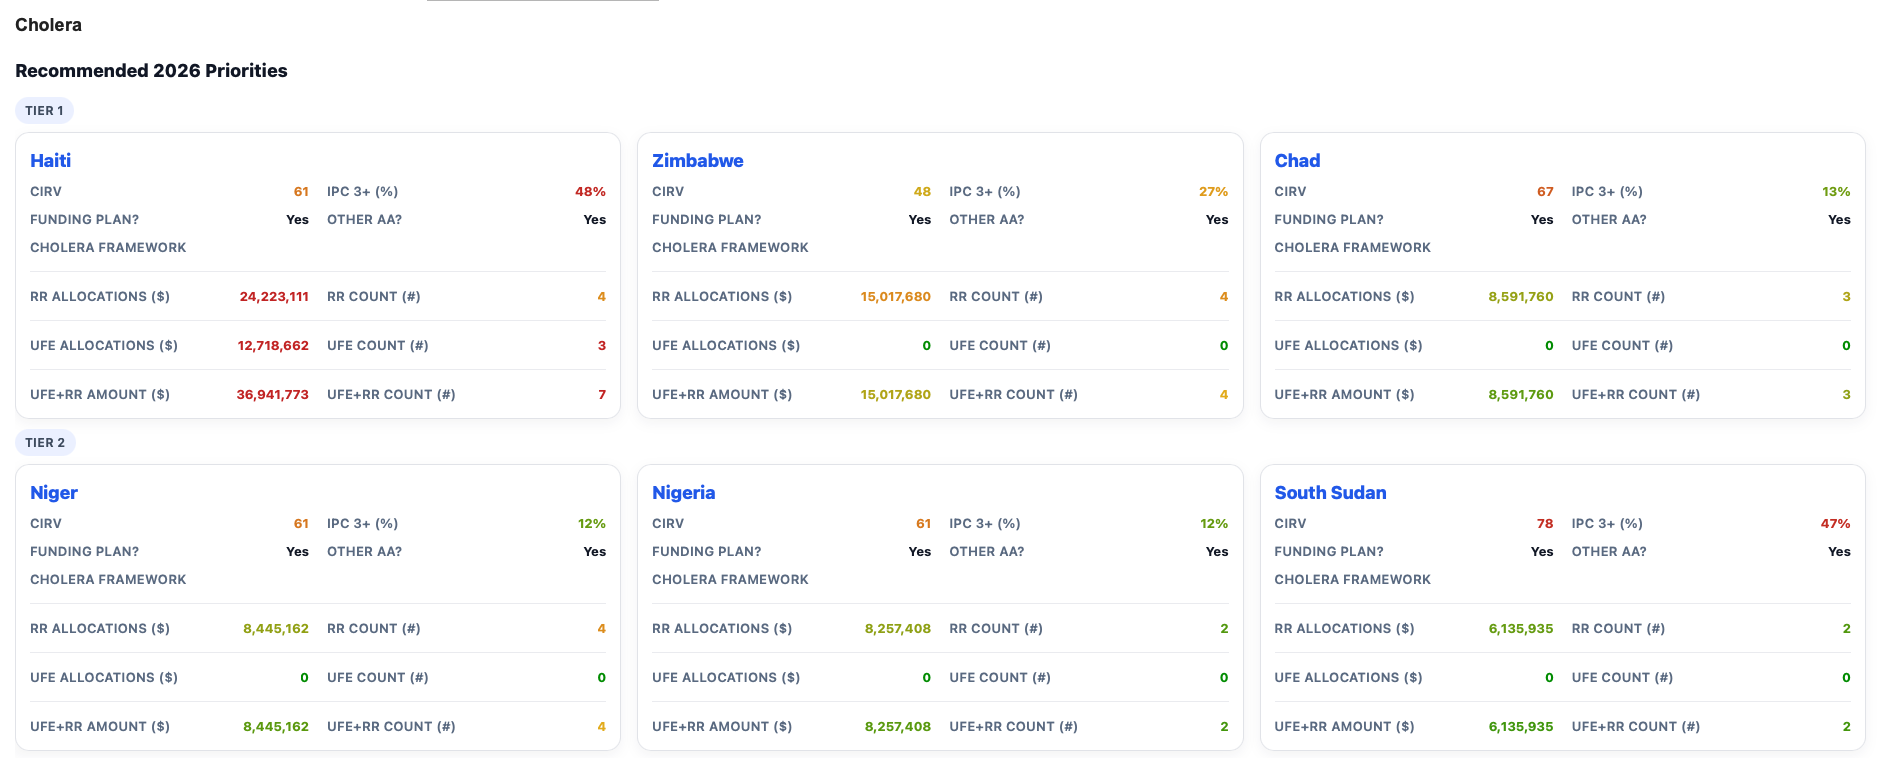

### Drought: Zimbabwe, Angola, and Mauritania
**Zimbabwe:** Zimbabwe has received 10 RR allocations for drought, totaling in $57.0MM, and has a CIRV score of 48. It has received allocations three out of the last five years, with the last allocation in 2024. Zimbabwe currently does not currently have an IPC classification but had one almost every year from 2012-2020. Zimbabwe saw drought-related anticipatory action frameworks activated throughout 2024 with ACF, WHH, and the Start Network. Drought-related anticipatory action frameworks are being currently developed for Zimbabwe through the ACF and WHH.

**Angola:** Angola has received 6 RR allocations totaling $27.9MM, withUFE+RR totaling 33.9MM. Its CIRV score of 38 reflects a moderate risk level compared to other countries, but repeated allocations highlight persistent drought-related challenges. Its most recent allocation for drought was an RR allocation in 2024. Angola does not currently have an IPC classification but had Acute Food Insecurity in 2019-2020 and 2021-2022 and Acute Malnutrition Classification 2021-2022. Angola had drought-related anticipatory action frameworks with the Start Network and UNICEF activated in May 2024.

**Mauritania:** Mauritania has had 7 UFE + RR allocations in total, amounting to  21.6MM; 6 of these allocations are RR, totaling 15.6MM. Its last drought-related allocation was in 2020. Its CIRV score is 42 and increasing, as outlined below. Mauritania currently has food security, with 12% of the population in IPC 3. Mauritania currently has drought-related anticipatory action frameworks being developed by the WFP. Mauritania is not a HRNP country.

**Additional Modifications:**

- Somalia: used to have framework. Would be much better placed.
- Ethiopia: recommended

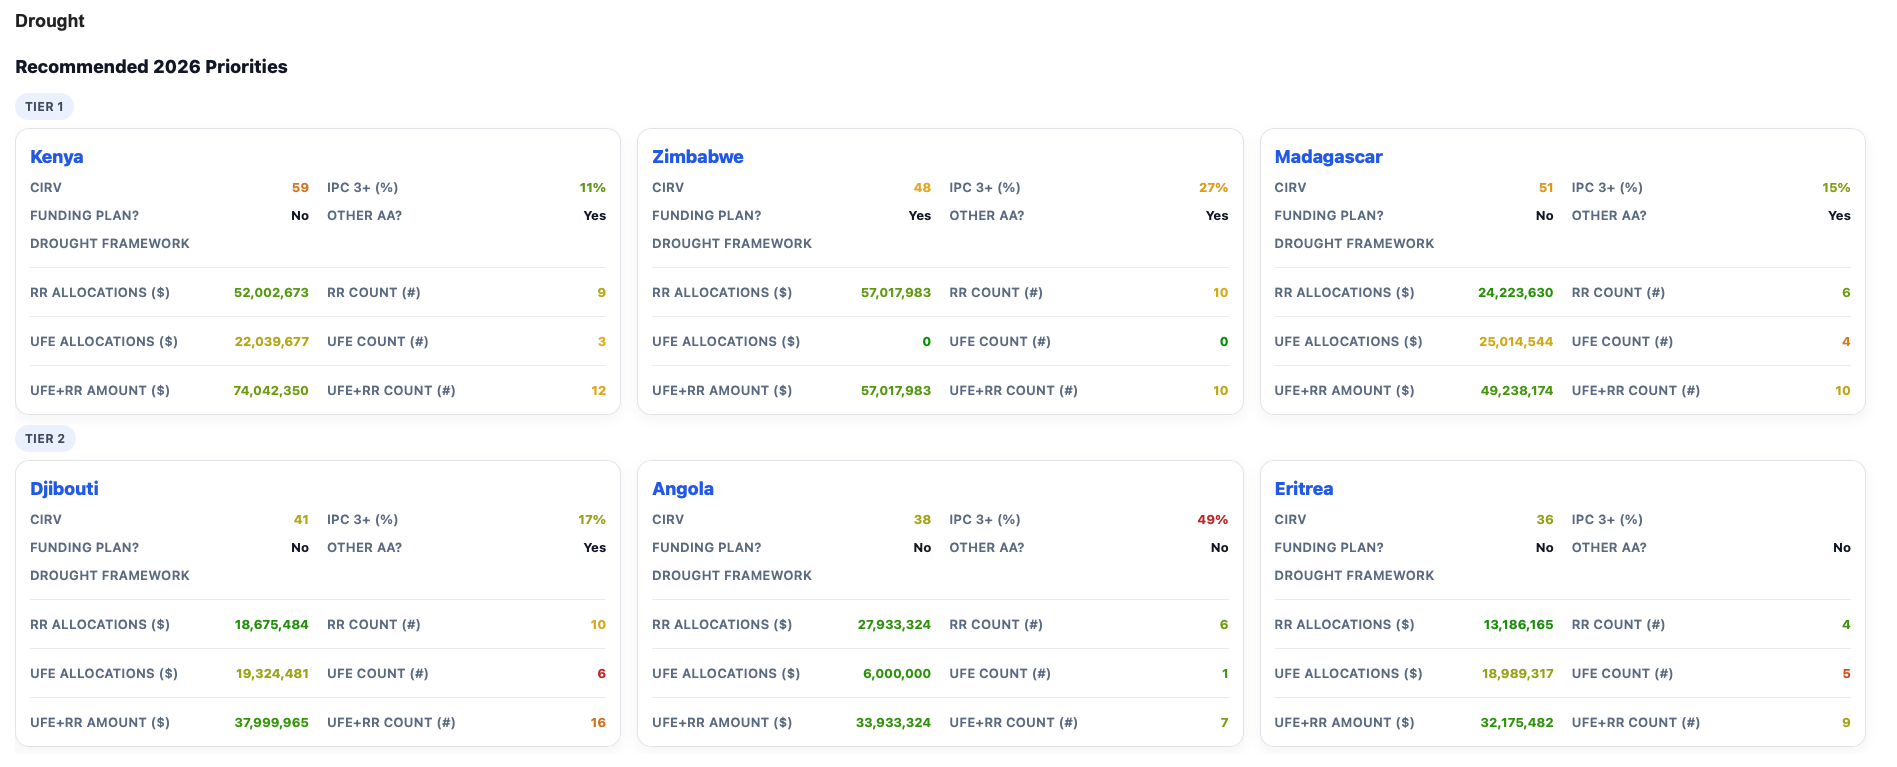

### Floods: Somalia and Mozambique
**Somalia:** Somalia has received 5 RR allocations, totaling $40.7MM and has a CIRV score of 75, indicating relatively high vulnerability. Its last flood-related allocation was in 2023. Somalia has had flood-related anticipatory action frameworks through the Danish Refugee Council, WFP, the Start Network, and the FAO activated throughout 2024. The FAO and Education Cluster are also currently developing flood-related anticipatory action frameworks for Somalia.

**Mozambique [manual add]:** Mozambique has received 6 RR allocations, totaling $24.5MM, and has a CIRV score of 61. Its last flood-related allocation was in 2015. Mozambique has had flood-related anticipatory action frameworks from

**Additional modifications:**
- Pakistan: Manually removed due to high government capacity; AA frameworks may not have material impact.
- South Sudan: Manually removed. Flooding happens every year, meaning how we fund these shocks should change (either added to programmatic budget or set criteria higher so that AA is not responding everytime).

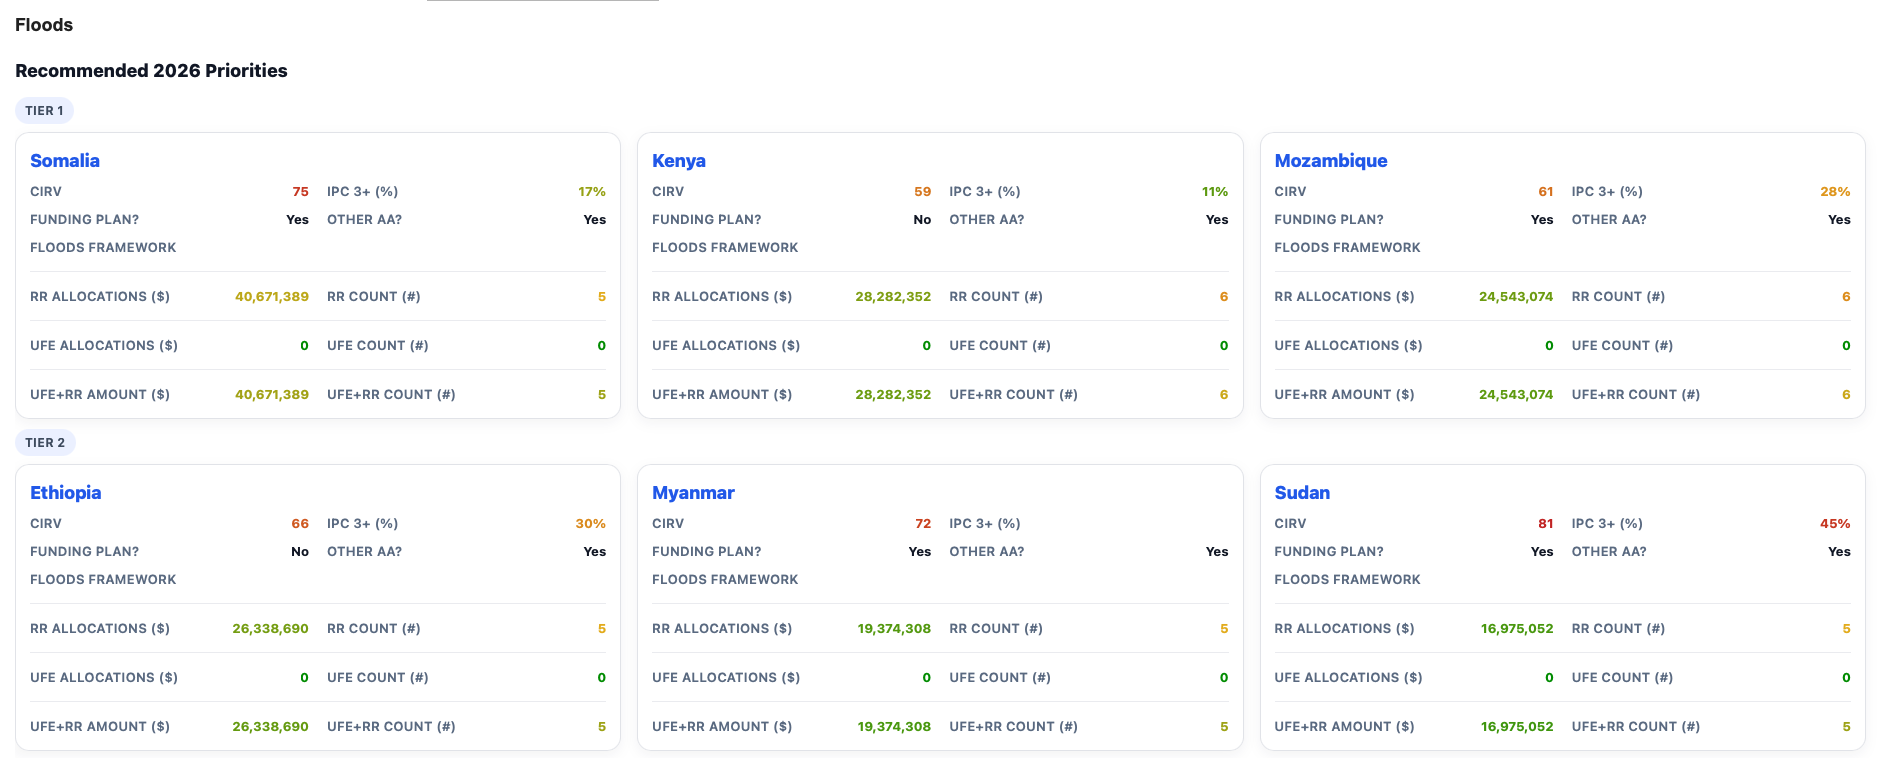

## Storms: Malawi, Vanuatu, and Guatemala

**Malawi:** Malawi has received 3 RR allocations worth $11.9MM. Including UFE, it has had 4 allocations in total, including UFE, reaching 15.8MM. Its CIRV of 49 reflects a moderate risk, with allocations clustered in 2019–2023. Malawi had a cyclone/hurricane/tropical storm/typhoon anticipatory action framework supported by the Danish Red Cross, activated in December 2024. [in-country capacity unclear]

**Vanuatu:** Vanuatu has had 4 RR allocations totaling $10.4MM and a CIRV of 21. It received two storm-related RR allocations in 2023. It had hurricane AA framework in 2024 and also has hurricane-related AA frameworks under development.

**Guatemala:** Guatemala, with 4 RR allocations totaling $9.6MM and a CIRV of 46, shows a risk profile closer to Malawi, warranting sustained monitoring and funding. Its last allocation was in 2020. Guatemala had a cyclone/hurricane/tropical storm/typhoon anticipatory action framework supported by Start Network, activated once in March 2024 and once in June 2024. Guatemala also a has drought framework so monitoring a synergy could be interesting.

**Additional modifications:**
- Nicaragua: Removed because Nicaraguan government withdrew from various UN agencies

**Additional notes:**
Though we could develop a regional framework for El Salvador, Nicaragua, and Guatemala, Nicaraguan government withdrew from various UN agencies so developing an AA framework is not possible.

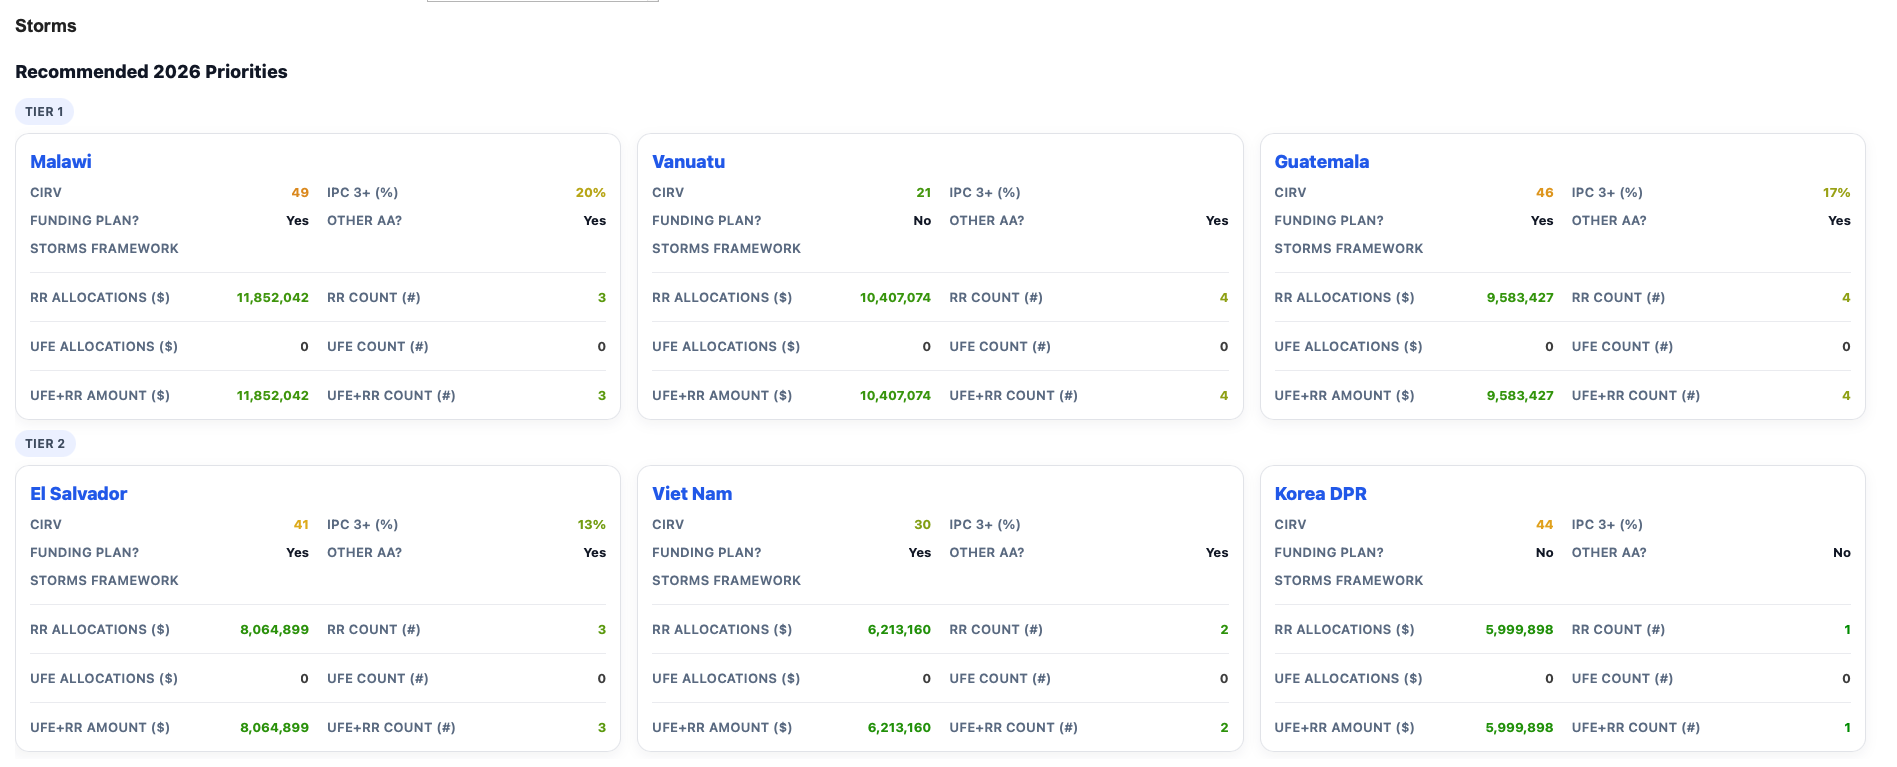

---



## Feedback Form

In [ ]:
# --- Public Feedback Form (no header text; Name/Email optional) ---
from IPython.display import HTML, display

display(HTML(r"""
<style>
#fb-wrap{
  margin: 18px 0 10px 0;
  padding: 16px;
  border: 1px solid #e5e7eb;
  border-radius: 14px;
  background: #ffffff;
  box-shadow: 0 4px 12px rgba(15,23,42,.05);
  font-family: Inter, system-ui, -apple-system, "Segoe UI", Roboto, Helvetica, Arial, "Noto Sans";
}
#fb-form .row{ display: grid; grid-template-columns: 1fr 1fr; gap: 10px; }
#fb-form .row.single{ grid-template-columns: 1fr; }
#fb-form label{ font-size: 12px; color:#64748b; font-weight:700; text-transform:uppercase; letter-spacing:.3px; display:block; margin-bottom: 6px; }
#fb-form input[type="text"], #fb-form input[type="email"], #fb-form select, #fb-form textarea{
  width: 100%; box-sizing:border-box;
  border: 1px solid #e5e7eb; border-radius: 10px; padding: 10px 12px; font-size: 14px; color:#0f172a; background:#fff;
}
#fb-form textarea{ min-height: 120px; resize: vertical; }
#fb-form .actions{ margin-top: 12px; display:flex; align-items:center; gap:10px; }
#fb-submit{
  appearance:none; border:1px solid #dbe0e6; background:#2563eb; color:#fff;
  border-radius: 999px; padding: 10px 16px; font-weight:800; letter-spacing:.2px; font-size: 13px;
  box-shadow: 0 2px 8px rgba(37,99,235,.25); cursor:pointer; transition: transform .05s ease, box-shadow .12s ease, opacity .12s ease;
}
#fb-submit:hover{ transform: translateY(-1px); box-shadow: 0 6px 16px rgba(37,99,235,.28); }
#fb-submit[disabled]{ opacity:.6; cursor:not-allowed; transform:none; box-shadow:none; }
#fb-msg{ font-size:12px; color:#475569; }
#fb-error{ color:#b91c1c; font-weight:700; }
#fb-success{ color:#166534; font-weight:700; }
</style>

<div id="fb-wrap">
  <form id="fb-form" method="POST" action="https://formsubmit.co/sumana.palle@un.org">
    <!-- Email routing -->
    <input type="hidden" name="_cc" value="sp4454@columbia.edu">
    <input type="hidden" name="_subject" id="fb-subject" value="AA Feedback">
    <input type="hidden" name="_template" value="table">
    <input type="hidden" name="_captcha" value="true">
    <input type="hidden" name="_next" id="fb-next" value="https://formsubmit.co/thank-you">

    <!-- Spam protection -->
    <input type="text"  name="honeypot" id="fb-hpot1" style="display:none" tabindex="-1" autocomplete="off">
    <input type="text"  name="_honey"   id="fb-hpot2" style="display:none" tabindex="-1" autocomplete="off">
    <input type="hidden" name="ts" id="fb-ts" value="">
    <input type="hidden" name="page" id="fb-page" value="">

    <div class="row">
      <div>
        <label for="fb-name">Your Name (optional)</label>
        <input type="text" id="fb-name" name="name" placeholder="e.g., Jane Doe">
      </div>
      <div>
        <label for="fb-email">Your Email (optional)</label>
        <input type="email" id="fb-email" name="_replyto" placeholder="For follow-up (optional)">
      </div>
    </div>

    <div class="row single" style="margin-top:10px;">
      <div>
        <label for="fb-cat">Category <span style="color:#b91c1c">*</span></label>
        <select id="fb-cat" name="Category" required>
          <option value="" selected disabled>Choose one…</option>
          <option>Recommendations on AA Frameworks</option>
          <option>Feedback on the Dashboard</option>
        </select>
      </div>
    </div>

    <div class="row single" style="margin-top:10px;">
      <div>
        <label for="fb-msgbox">Message <span style="color:#b91c1c">*</span></label>
        <textarea id="fb-msgbox" name="Message" required placeholder="Write your feedback…"></textarea>
      </div>
    </div>

    <div class="actions">
      <button id="fb-submit" type="submit">Send Feedback</button>
      <span id="fb-msg" aria-live="polite"></span>
    </div>
  </form>
</div>

<script>
(function(){
  var form   = document.getElementById('fb-form');
  var btn    = document.getElementById('fb-submit');
  var msg    = document.getElementById('fb-msg');
  var subject= document.getElementById('fb-subject');
  var ts     = document.getElementById('fb-ts');
  var page   = document.getElementById('fb-page');
  var next   = document.getElementById('fb-next');
  var cat    = document.getElementById('fb-cat');
  var nameEl = document.getElementById('fb-name');
  var emailEl= document.getElementById('fb-email');
  var box    = document.getElementById('fb-msgbox');
  var h1     = document.getElementById('fb-hpot1');
  var h2     = document.getElementById('fb-hpot2');

  // Initialize anti-spam values
  var start = Date.now();
  ts.value = String(start);
  try { page.value = window.location.href; } catch(e){}

  // Return to current page with a #thank-you anchor
  try {
    var url = new URL(window.location.href);
    url.hash = '#thank-you';
    next.value = url.toString();
  } catch(e){ /* leave default */ }

  // Client-side validation + light anti-spam
  form.addEventListener('submit', function(ev){
    // Honeypots must be empty
    if ((h1.value || '').trim() !== '' || (h2.value || '').trim() !== '') {
      ev.preventDefault();
      msg.innerHTML = "<span id='fb-error'>Blocked as spam.</span>";
      return false;
    }
    // Time gate (3s)
    if (Date.now() - start < 3000) {
      ev.preventDefault();
      msg.innerHTML = "<span id='fb-error'>Please take a moment before submitting.</span>";
      return false;
    }
    // Rate limit: 1/min
    try {
      var last = parseInt(localStorage.getItem('fb-last') || '0', 10);
      if (Date.now() - last < 60000) {
        ev.preventDefault();
        msg.innerHTML = "<span id='fb-error'>Please wait a minute before submitting another response.</span>";
        return false;
      }
    } catch(e){}

    // Required fields
    if (!cat.value) {
      ev.preventDefault();
      msg.innerHTML = "<span id='fb-error'>Please choose a category.</span>";
      return false;
    }
    if (!box.value || box.value.trim().length < 10) {
      ev.preventDefault();
      msg.innerHTML = "<span id='fb-error'>Please provide a bit more detail (10+ characters).</span>";
      return false;
    }

    // Dynamic email subject
    var nm = (nameEl.value || '').trim();
    subject.value = "AA Feedback — " + cat.value + (nm ? (" — " + nm) : "");

    // UI feedback
    btn.setAttribute('disabled', 'disabled');
    btn.textContent = 'Sending…';
    msg.textContent = 'Submitting…';

    try { localStorage.setItem('fb-last', String(Date.now())); } catch(e){}
  }, false);
})();
</script>
"""))
